## Naive Bayes

Import necessary libraries to perform Naive Bayes Classification.

In [110]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve, auc
import numpy as np
from sklearn.preprocessing import MaxAbsScaler
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

### 1. Data Prep for ML

Unpickle data and remove any NA values.

Concate "comment" and "parent_comment" for TD-idf and BoW from training and testing datasets using vstack.

In [111]:
train = pd.read_pickle("data/train.pkl").dropna()
test = pd.read_pickle("data/test.pkl").dropna()

In [112]:
train_parent_tdidf_csr = vstack(train["parent_comment_tdidf"])
test_parent_tdidf_csr = vstack(test["parent_comment_tdidf"])

train_tdidf_csr = vstack(train["comment_tdidf"])
test_tdidf_csr = vstack(test["comment_tdidf"])

train_parent_bow_csr = vstack(train["parent_comment_bow"])
test_parent_bow_csr = vstack(test["parent_comment_bow"])

train_bow_csr = vstack(train["comment_bow"])
test_bow_csr = vstack(test["comment_bow"])

In [113]:
train.columns

Index(['comment', 'parent_comment', 'comment_tokens', 'parent_comment_tokens',
       'comment_tokens_bigram', 'parent_comment_tokens_bigram',
       'comment_tokens_trigram', 'parent_comment_tokens_trigram',
       'comment_score', 'parent_comment_score',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive', 'comment_word_count',
       'parent_comment_word_count', 'comment_token_count',
       'parent_comment_token_count', 'comment_unique_word_count',
       'parent_comment_unique_word_count', 'comment_unique_token_count',
       'parent_comment_unique_token_count', 'comment_stopword_count',
       'parent_comment_stopword_count', 'comment_mean_word_length',
       'parent_comment_mean_word_length', 'comment_mean_token_length',
       'parent_comment_mean_token_length', 'comment_char_count',
       'parent_comment_char_count', 'comment_

List of features necessary for Naive Bayes classification.

In [114]:
list_of_features = [
       'comment_word_count','parent_comment_word_count',
       'comment_token_count', 'parent_comment_token_count',
       'comment_unique_word_count', 'parent_comment_unique_word_count',
       'comment_unique_token_count', 'parent_comment_unique_token_count',
       'comment_stopword_count', 'parent_comment_stopword_count',
       'comment_mean_word_length', 'parent_comment_mean_word_length',
       'comment_mean_token_length', 'parent_comment_mean_token_length',
       'comment_char_count', 'parent_comment_char_count',
       'comment_punctuation_count', 'parent_comment_punctuation_count',
       'comment_hashtag_count', 'parent_comment_hashtag_count',
       'comment_number_count', 'parent_comment_number_count',
       'weighted_parent_sentiment_score_neutral',
       'weighted_parent_sentiment_score_positive',
       'weighted_comment_sentiment_score_neutral',
       'weighted_comment_sentiment_score_positive']

Here we will standardize columns with boolean values. We will change from boolean to integer type and convert the features from a dense matrix to a sparse matrix using the function csr_matrix.

In [115]:
bool_cols = ['weighted_parent_sentiment_score_neutral',
             'weighted_parent_sentiment_score_positive',
             'weighted_comment_sentiment_score_neutral',
             'weighted_comment_sentiment_score_positive']

for col in bool_cols: #need to convert bool type to integer
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)
X_train_gen_features = csr_matrix(train[list_of_features])
y_train_LR = train['label']

X_test_gen_features = csr_matrix(test[list_of_features])
y_test_LR = test['label']

### 2. Finding Best combination of Features

### Baseline 1: General Features

Performing Multinomial Naive Bayes classification using General Features as the baseline.

We will first train the training data using the MultinomialNB() model. We will then make predictions and compare the actual values and predicted values using the mean and stardard deviation of the area under the ROC curve. By looking at the difference in the area under curve measurements we can evaluate the accuracy and precision of logistic regression for this dataset.

In [116]:
X_train_LR = X_train_gen_features

In [117]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5053108414551877
Standard Deviation of roc_auc: 0.00491743706424603


### Baseline 2: Comment BoW

Performing Multinomial Naive Bayes classification using Comment Bag of Words as the baseline.

In [118]:
X_train_LR = train_bow_csr

In [119]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6439986874851111
#unigram: Standard Deviation of roc_auc: 0.0015538454889143783

Mean roc_auc: 0.6539451398593382
Standard Deviation of roc_auc: 0.0018663773341545445


### Baseline 3: Comment TD-IDF

Performing Multinomial Naive Bayes classification using Comment TD-idf as the baseline.

In [120]:
X_train_LR = train_tdidf_csr

In [121]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")
#unigram: Mean roc_auc: 0.6392604315512
#unigram: Standard Deviation of roc_auc: 0.0014945661295342496

Mean roc_auc: 0.6516729123224697
Standard Deviation of roc_auc: 0.0016794671113447989


### Baseline 4: General Features + BoW

Performing Multinomial Naive Bayes classification using both General Features and Comment Bag of Words as the baseline.

In [122]:
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [123]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.6346011511337147
Standard Deviation of roc_auc: 0.009129336279886418


### Baseline 5: General Features + TD-IDF

Performing Multinomial Naive Bayes classification using General Features and Comment TD-idf as the baseline.

In [124]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

In [125]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5856576299149585
Standard Deviation of roc_auc: 0.01455822864352804


### Baseline 6: Gen Features + Comment TDIDF + Parent TDIDF

Performing Multinomial Naive Bayes classification using General Features, Comment TD-idf and Parent comment TD-idf as the baseline.

In [126]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr,train_parent_tdidf_csr])

In [127]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5976400104468006
Standard Deviation of roc_auc: 0.014213097801530149


### Baseline 7: Gen + Parent TDIDF

Performing Multinomial Naive Bayes classification using General Features and Parent comment TD-idf as the baseline.

In [128]:
X_train_LR = hstack([X_train_gen_features,train_parent_tdidf_csr])

In [129]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5272753565019327
Standard Deviation of roc_auc: 0.006666106199031639


### 3. Base Model
Using Baseline 5: General Features + TF-IDF

In [130]:
X_train_LR = hstack([X_train_gen_features,train_tdidf_csr])

Running 5-fold cross validation

In [131]:
k = 5

model = MultinomialNB()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

cross_val_scores = []
for train_index, val_index in kf.split(X_train_LR):
    X_train, X_val = X_train_LR[train_index], X_train_LR[val_index]
    y_train, y_val = y_train_LR.iloc[train_index,], y_train_LR.iloc[val_index,]

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Calculate roc_auc and store it in the list
    roc_auc = roc_auc_score(y_val, y_pred)
    cross_val_scores.append(roc_auc)

mean_roc_auc = sum(cross_val_scores) / k
std_roc_auc = np.std(cross_val_scores)

print(f"Mean roc_auc: {mean_roc_auc}")
print(f"Standard Deviation of roc_auc: {std_roc_auc}")

Mean roc_auc: 0.5856576299149585
Standard Deviation of roc_auc: 0.01455822864352804


Evaluating Base model on Test Set

In [132]:
# Train Baseline Model on whole training set
model = MultinomialNB()
model.fit(X_train_LR, y_train_LR)

# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_tdidf_csr])
y_pred_test = model.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.5891853835713412


ROC curve on Test set

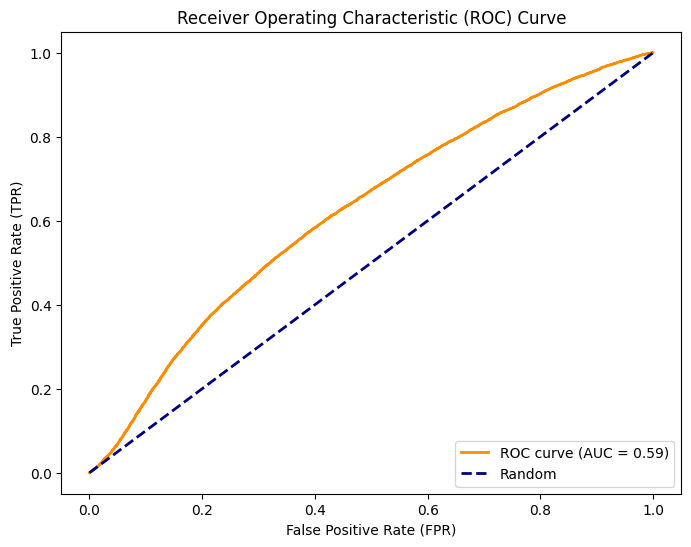

In [133]:
# Obtain Probability Scores
y_scores = model.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explanability

In [200]:



neg_class_prob_sorted = model.feature_log_prob_[0, :].argsort()[::-1]
pos_class_prob_sorted = model.feature_log_prob_[1, :].argsort()[::-1]


print(neg_class_prob_sorted)
print(pos_class_prob_sorted)

[   15    14     1 ... 25514 32687 41430]
[   15    14     1 ... 19720 33693 21959]


### 4. Hyper Parameter Tuning with Grid Search CV

Baseline 5: General Features + BoW has the highest mean roc_auc score (0.63460). This means that it is the best performing classifier. We will now perform hyperparameter tuning on this to increase the model performance. We will use GridSearchCV to cross validate all possible hyperparameter combinations and pick the best performing hyperparameters.

In [135]:
### Using gen features and bow
X_train_LR = hstack([X_train_gen_features,train_bow_csr])

In [136]:
param_grid = {
    'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],  # You can extend this list
    'fit_prior': [True, False],
}

In [137]:
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='roc_auc', verbose=4)
grid_search.fit(X_train_LR, y_train_LR)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .........alpha=0.2, fit_prior=True;, score=0.688 total time=   0.0s
[CV 2/5] END .........alpha=0.2, fit_prior=True;, score=0.666 total time=   0.0s
[CV 3/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 4/5] END .........alpha=0.2, fit_prior=True;, score=0.684 total time=   0.0s
[CV 5/5] END .........alpha=0.2, fit_prior=True;, score=0.681 total time=   0.0s
[CV 1/5] END ........alpha=0.2, fit_prior=False;, score=0.688 total time=   0.0s
[CV 2/5] END ........alpha=0.2, fit_prior=False;, score=0.666 total time=   0.0s
[CV 3/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 4/5] END ........alpha=0.2, fit_prior=False;, score=0.684 total time=   0.0s
[CV 5/5] END ........alpha=0.2, fit_prior=False;, score=0.681 total time=   0.0s
[CV 1/5] END .........alpha=0.4, fit_prior=True;, score=0.690 total time=   0.0s
[CV 2/5] END .........alpha=0.4, fit_prior=True;

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.2, 0.4, 0.6, 0.8, 1.0],
                         'fit_prior': [True, False]},
             scoring='roc_auc', verbose=4)

In [138]:
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Best score achieved during grid search
best_score = grid_search.best_score_
print("Best Score:", best_score)

Best Parameters: {'alpha': 0.6, 'fit_prior': True}
Best Score: 0.6819322827550783


Here we will test out the model using the best hyperparameters.

In [139]:
# Best estimator (the fitted model with the best parameters)
best_estimator = grid_search.best_estimator_
print("Best Estimator:", best_estimator)

# Results for all parameter combinations
cv_results = grid_search.cv_results_

Best Estimator: MultinomialNB(alpha=0.6)


In [140]:
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']
params = cv_results['params']

pd.set_option('display.max_colwidth',None)
results_df = pd.DataFrame({'Params':params,'Mean Score':mean_test_scores,'STD':std_test_scores})
results_df["Params"] = results_df["Params"].apply(lambda x: ', '.join([f'{key}: {value}' for key, value in x.items()]))
results_df.sort_values('STD', inplace=True)
results_df.sort_values('Mean Score', ascending=False,inplace=True)
results_df


#for mean_score, std_score, param in zip(mean_test_scores, std_test_scores, params):
    #print(f"Mean Score: {mean_score:.3f} (±{std_score:.3f}) for params: {param}")

,Params,Mean Score,STD
4,"alpha: 0.6, fit_prior: True",0.681932,0.008536
5,"alpha: 0.6, fit_prior: False",0.681932,0.008536
6,"alpha: 0.8, fit_prior: True",0.681787,0.008815
7,"alpha: 0.8, fit_prior: False",0.681787,0.008815
2,"alpha: 0.4, fit_prior: True",0.681644,0.008160
3,"alpha: 0.4, fit_prior: False",0.681644,0.008160
8,"alpha: 1.0, fit_prior: True",0.681450,0.009036
9,"alpha: 1.0, fit_prior: False",0.681450,0.009036
0,"alpha: 0.2, fit_prior: True",0.680133,0.007558
1,"alpha: 0.2, fit_prior: False",0.680133,0.007558


Evaluating Optimized Model on test set

In [141]:
# Evaluate AUC_ROC
X_test_LR = hstack([X_test_gen_features,test_bow_csr])
y_pred_test = best_estimator.predict(X_test_LR)
roc_auc_test = roc_auc_score(y_test_LR, y_pred_test)
print(f"roc_auc test: {roc_auc_test}")

roc_auc test: 0.6398838026998598


ROC Curve on test set

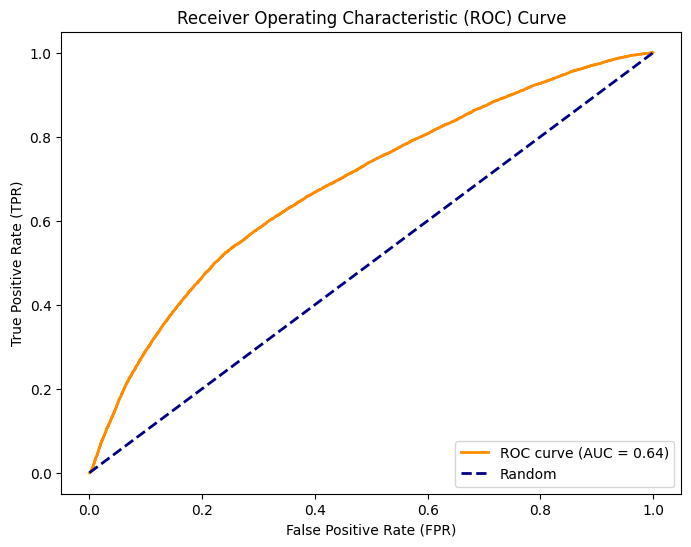

In [142]:
# Obtain Probability Scores
y_scores = best_estimator.predict_proba(X_test_LR)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_LR, y_scores)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc_test))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Model Explanability